In [1]:
import os, natsort, re
from tqdm import tqdm
import time, random

In [2]:
from itertools import repeat, chain

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("fivethirtyeight")
# 이미지가 레이아웃 안으로 들어오도록 함
mpl.rcParams.update({"figure.constrained_layout.use": True})
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
#cd /content/drive/MyDrive/AI3_prjct2_aladin/

In [5]:
cd /content/drive/MyDrive/kdt-EST-AI/project/project2/

/content/drive/MyDrive/kdt-EST-AI/project/project2


In [6]:
# 로컬에서

#plt.rc("font", family = "D2Coding")
#plt.rcParams["axes.unicode_minus"] = False

In [7]:
#PRJCT_PATH = '/home/doeun/code/AI/ESTSOFT2024/workspace/2.project_text/aladin_usedbook/'
PRJCT_PATH = '/content/drive/MyDrive/kdt-EST-AI/project/project2/'
#PRJCT_PATH = '/content/drive/MyDrive/AI3_prjct2_aladin/aladin_usedbook/'
save_dir = 'processed/model_input'
dir_path = os.path.join(PRJCT_PATH,save_dir)
#dir_path = './'

In [8]:
ls

 aladin_usedbook.gslides                  module_aladin/   research/
'aladin_usedbook 발표자료 초고.gslides'   processed/


In [9]:
import sys
sys.path.append(PRJCT_PATH)

In [10]:
RSLT_DIR = PRJCT_PATH + 'processed/'

bookinfo_name = 'bookinfo_ver{}.pkl'.format(0.75)
bookinfo_path = os.path.join(RSLT_DIR,bookinfo_name)

sys.path.append(PRJCT_PATH)
from module_aladin.file_io import load_pkl, save_pkl
from module_aladin.data_process import pd_datetime_2_datenum
from module_aladin.reg_tool import make_reg_score_dict

from sklearn.preprocessing import MinMaxScaler

In [11]:
input_dir = os.path.join(RSLT_DIR,'model_input')
files = list(filter(lambda x : 'prd_rglr' in x,os.listdir(input_dir)))
files

['prd_rglr.v1.0_st-0_y_trn.pkl',
 'prd_rglr.v1.0_st-0_X_tst.pkl',
 'prd_rglr.v1.0_st-0_X_trn.pkl',
 'prd_rglr.v1.0_st-0_y_tst.pkl',
 'prd_rglr.v1.0_st-0_X_vld.pkl',
 'prd_rglr.v1.0_st-0_y_vld.pkl']

In [12]:
from collections import defaultdict

data_dict=defaultdict(dict)
for f in files:
    data_dict[f[-7:-4]][f[-9]] = load_pkl(os.path.join(input_dir,f))

In [13]:
data_dict.keys()

dict_keys(['trn', 'tst', 'vld'])

In [14]:
np.sum(np.isnan(data_dict['trn']['X']))

0

In [15]:
display(data_dict['trn']['X'].shape)
display(data_dict['trn']['X'][0,:])


(101173, 65)

array([0.00000000e+00, 7.68816791e-05, 7.36015702e-04, 1.24533001e-03,
       3.84615385e-02, 1.05148138e-01, 5.30719281e-04, 2.37228788e-01,
       1.95478391e-02, 3.43460205e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

## make dataloader

In [16]:
cols_tknz = ['Category','BName','BName_sub']
cols_scalar = ['Author','Author_mul','Publshr','Pdate', 'SalesPoint']
maxlens={
    'Category' : 5,
    'BName' : 30,
    'BName_sub' : 25
}
col_idx = [0,5,35,60,61,62,63,64,65]
col_start = [0,5,35,60,65]

In [17]:
def polish_idx(length,crop_idx):
    crop_idx2 = list(map(lambda x : length + x if x < 0 else x, crop_idx))
    return sorted(crop_idx2,reverse=True)

def make_cropped_data(crop_idx, X):
    crop_idx = polish_idx(X.shape[1],crop_idx)
    for i in crop_idx:
        X = np.hstack([X[:,:i],X[:,i+1:]])
    return X

In [18]:

import torch

# GPU device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [19]:
import torch
from torch.utils.data import TensorDataset

crop_idx = [-1]

dataset = defaultdict(dict)
for mode, data in data_dict.items():
  X, y = data['X'], data['y']
  X = make_cropped_data(crop_idx,X)
  dataset[mode] = TensorDataset(torch.tensor(X).to(device),torch.tensor(y).to(device))

In [20]:
#https://davi06000.tistory.com/102

from torch.utils.data import DataLoader

class DataLoaderDict :
  def __init__(self,dataset):
    self.dataset = dataset
  def make_iter(self,batch_size):
    return {
        mode : DataLoader(data,batch_size)#,num_workers = 32)
        for mode, data in self.dataset.items()
    }

# Make model & setting

In [21]:
import math
import time

from torch import nn, optim
from torch.optim import Adam


In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.kaiming_uniform(m.weight.data)


In [23]:
# model parameter setting
batch_size = 512

# optimizer parameter setting
init_lr = 1e-2#*3
factor = 0.9995
adam_eps = 5e-9
patience = 10
warmup = 3
epoch = 300
clip = 1.0
weight_decay = 5e-7
drop_prob = 0.1

In [24]:
#https://sonstory.tistory.com/84

from torch.nn import functional as F

class BasicModel(nn.Module):
  def __init__(self,drop_prob):
    super().__init__()
    #self.fc1 = nn.Linear(64,64,bias=True)
    self.fc3 = nn.Linear(64,32,bias=True)
    self.fc4 = nn.Linear(32,32,bias=True)
    self.fc5 = nn.Linear(32,32,bias=True)
    self.fc6 = nn.Linear(32,32,bias=True)
    self.fc7 = nn.Linear(32,32,bias=True)
    self.fc8 = nn.Linear(32,8,bias=True)
    self.fc9 = nn.Linear(8,1,bias=True)
    self.dropout = nn.Dropout(drop_prob)

  def forward(self,X):
    #X = F.relu(self.fc1(X))
    #X = (F.relu(self.fc2(X)))
    X = self.dropout(F.relu(self.fc3(X)))
    X = (F.relu(self.fc4(X)))
    X = self.dropout(F.relu(self.fc5(X)))
    X = self.dropout(F.relu(self.fc6(X)))
    X = self.dropout(F.relu(self.fc7(X)))
    X = self.dropout(F.relu(self.fc8(X)))
    return F.relu(self.fc9(X))

In [25]:
# model parameter setting
batch_size =1024#512#1024#512

# optimizer parameter setting
init_lr = 1.5*1e-2#5*1e-3#*3
factor = 0.999995
adam_eps = 5e-7
patience = 15
warmup = 3
epoch = 300
clip = 1.0
weight_decay = 5e-9
drop_prob = 0.1

In [26]:
#https://sonstory.tistory.com/84

from torch.nn import functional as F

class BasicModel2(nn.Module):
  def __init__(self,drop_prob):
    super().__init__()
    #self.fc1 = nn.Linear(64,64,bias=True)
    self.fc3 = nn.Linear(64,32,bias=True)
    #self.fc4 = nn.Linear(32,32,bias=True)
    self.fc5 = nn.Linear(32,32,bias=True)
#    self.fc6 = nn.Linear(32,32,bias=True)
    self.fc7 = nn.Linear(32,32,bias=True)
    self.fc8 = nn.Linear(32,8,bias=True)
    self.fc9 = nn.Linear(8,1,bias=True)
    self.dropout = nn.Dropout(drop_prob)

  def forward(self,X):
    #X = F.relu(self.fc1(X))
    #X = (F.relu(self.fc2(X)))
    X = self.dropout(F.relu(self.fc3(X)))
    #X = (F.relu(self.fc4(X)))
    X = self.dropout(F.relu(self.fc5(X)))
 #   X = self.dropout(F.relu(self.fc6(X)))
    X = self.dropout(F.relu(self.fc7(X)))
    X = self.dropout(F.relu(self.fc8(X)))
    return F.relu(self.fc9(X))

class BasicModel2b(nn.Module):
  def __init__(self,drop_prob):
    super().__init__()
    self.fc3 = nn.Linear(64,32,bias=True)
    self.fc5 = nn.Linear(32,32,bias=True)
    self.fc7 = nn.Linear(32,32,bias=True)
    self.fc8 = nn.Linear(32,8,bias=True)
    self.fc9 = nn.Linear(8,1,bias=True)
    self.dropout = nn.Dropout(drop_prob)
    self.bn1 = nn.BatchNorm1d(32)
    self.bn2 = nn.BatchNorm1d(32)
    self.bn3 = nn.BatchNorm1d(8)

  def forward(self,X):
    X = (F.relu(self.fc3(X)))
    X = self.dropout(F.relu(self.bn1(self.fc5(X))))
    X = self.dropout(F.relu(self.bn2(self.fc7(X))))
    X = self.dropout(F.relu(self.bn3(self.fc8(X))))
    return F.relu(self.fc9(X))

In [27]:
# model parameter setting
batch_size =1024#512#1024#512

# optimizer parameter setting
init_lr = 1.5*1e-2#5*1e-3#*3
factor = 0.999995
adam_eps = 5e-7
patience = 15
warmup = 3
epoch = 700
clip = 1.0
weight_decay = 5e-9
drop_prob = 0.1

In [28]:
#https://sonstory.tistory.com/84

from torch.nn import functional as F

class BasicModel3(nn.Module):
  def __init__(self,drop_prob):
    super().__init__()
    #self.fc1 = nn.Linear(64,64,bias=True)
    self.fc3 = nn.Linear(64,256,bias=True)
    #self.fc4 = nn.Linear(32,32,bias=True)
    self.fc5 = nn.Linear(256,32,bias=True)
#    self.fc6 = nn.Linear(32,32,bias=True)
    self.fc7 = nn.Linear(32,32,bias=True)
    self.fc8 = nn.Linear(32,8,bias=True)
    self.fc9 = nn.Linear(8,1,bias=True)
    self.dropout = nn.Dropout(drop_prob)

  def forward(self,X):
    #X = F.relu(self.fc1(X))
    #X = (F.relu(self.fc2(X)))
    X = self.dropout(F.relu(self.fc3(X)))
    #X = (F.relu(self.fc4(X)))
    X = self.dropout(F.relu(self.fc5(X)))
 #   X = self.dropout(F.relu(self.fc6(X)))
    X = self.dropout(F.relu(self.fc7(X)))
    X = self.dropout(F.relu(self.fc8(X)))
    return F.relu(self.fc9(X))

class BasicModel3b(nn.Module):
  def __init__(self,drop_prob):
    super().__init__()
    self.fc3 = nn.Linear(64,256,bias=True)
    self.fc5 = nn.Linear(256,32,bias=True)
    self.fc7 = nn.Linear(32,32,bias=True)
    self.fc8 = nn.Linear(32,8,bias=True)
    self.fc9 = nn.Linear(8,1,bias=True)
    self.dropout = nn.Dropout(drop_prob)
    self.bn1 = nn.BatchNorm1d(32)
    self.bn2 = nn.BatchNorm1d(32)
    self.bn3 = nn.BatchNorm1d(8)

  def forward(self,X):
    X = (F.relu(self.fc3(X)))
    X = self.dropout(F.relu(self.bn1(self.fc5(X))))
    X = self.dropout(F.relu(self.bn2(self.fc7(X))))
    X = self.dropout(F.relu(self.bn3(self.fc8(X))))
    return F.relu(self.fc9(X))

In [29]:
def trainer_setting(model,init_lr,weight_decay,adam_eps,factor,patience):
  print(f'The model has {count_parameters(model):,} trainable parameters')
  model.apply(initialize_weights)
  optimizer = Adam(params=model.parameters(),
                   lr=init_lr,
                   weight_decay=weight_decay,
                   eps=adam_eps)

  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                   verbose=True,
                                                   factor=factor,
                                                   patience=patience)

  criterion = nn.MSELoss()
  return(model,optimizer,scheduler,criterion)


In [30]:
loader = DataLoaderDict(dataset)
iter_dict = loader.make_iter(batch_size)

In [31]:
model = BasicModel3b(drop_prob).to(device)
model, optimizer, scheduler, criterion =trainer_setting(model,init_lr,weight_decay,adam_eps,factor,patience)

The model has 26,337 trainable parameters


<ipython-input-22-08dca87eb2d9>:7: FutureWarning: `nn.init.kaiming_uniform` is now deprecated in favor of `nn.init.kaiming_uniform_`.
  nn.init.kaiming_uniform(m.weight.data)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# train, evaluate

In [32]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        #x,y_actual = batch[0].to(device), batch[1].to(device)
        x,y_actual = batch[0], batch[1]
        x,y_actual = x.to(torch.float32),y_actual.to(torch.float32)
        optimizer.zero_grad()
        y_pred = model(x).reshape(-1)
        loss = criterion(y_pred,y_actual)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        #print('step :', round((i / len(iterator)) * 100, 2), '% , loss :', math.sqrt(loss.item()))

    return epoch_loss / len(iterator)


In [33]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 7.8 MB/s eta 0:00:00


In [34]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 27.3 MB/s eta 0:00:00


In [35]:
from torcheval.metrics import functional as F_metric

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    Y_actual, Y_pred = list(),list()
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            #x,y_actual = batch[0].to(device), batch[1].to(device)
            x,y_actual = batch[0], batch[1]
            x,y_actual = x.to(torch.float32),y_actual.to(torch.float32)
            optimizer.zero_grad()
            y_pred = model(x).reshape(-1)
            loss = criterion(y_pred,y_actual)

            epoch_loss += loss.item()

            score_list = list()
            Y_pred.append(y_pred)
            Y_actual.append(y_actual)

    Y_actual, Y_pred = torch.cat(Y_actual), torch.cat(Y_pred).reshape(-1)

    return epoch_loss / len(iterator), F_metric.r2_score(Y_pred,Y_actual)

In [36]:

def run(model,train_config,train_iter,valid_iter,total_epoch,device,best_loss):
    train_losses, valid_losses, scores = [], [], []
    optimizer, scheduler, criterion, clip = *train_config,
    for step in range(total_epoch):

        start_time = time.time()
        train_loss = train(model, train_iter, optimizer, criterion, clip)
        valid_loss, score = evaluate(model, valid_iter, criterion)
        end_time = time.time()

        if step > warmup:
            scheduler.step(valid_loss)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        scores.append(scores)
#        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), 'saved/model-{0}.pt'.format(valid_loss))

        print(f'Epoch: {step + 1}')# | Time: {epoch_mins}m {epoch_secs}s')
        #print(f'Epoch: {step + 1} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {math.sqrt(train_loss):.3f}') # | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\tVal Loss: {math.sqrt(valid_loss):.3f}') # |  Val PPL: {math.exp(valid_loss):7.3f}')
        print(f'\tVal Score: {score:.3f}')

    return model,train_losses,valid_losses

In [37]:
iter_dict.keys()

dict_keys(['trn', 'tst', 'vld'])

In [38]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_USE_CUDA_DSA"] = '1'

In [39]:
train_config =[optimizer, scheduler, criterion, clip]

In [40]:
model,train_loss,val_loss = run(model,train_config,iter_dict['trn'],iter_dict['vld'],700,device,20000)

Epoch: 1
	Train Loss: 18034.396
	Val Loss: 17594.042
	Val Score: -1.894
Epoch: 2
	Train Loss: 17994.034
	Val Loss: 17526.543
	Val Score: -1.871
Epoch: 3
	Train Loss: 17914.752
	Val Loss: 17426.221
	Val Score: -1.839
Epoch: 4
	Train Loss: 17815.563
	Val Loss: 17306.317
	Val Score: -1.800
Epoch: 5
	Train Loss: 17701.542
	Val Loss: 17153.199
	Val Score: -1.750
Epoch: 6
	Train Loss: 17578.606
	Val Loss: 17071.973
	Val Score: -1.724
Epoch: 7
	Train Loss: 17447.947
	Val Loss: 16821.451
	Val Score: -1.645
Epoch: 8
	Train Loss: 17305.019
	Val Loss: 16538.745
	Val Score: -1.557
Epoch: 9
	Train Loss: 17148.627
	Val Loss: 16549.824
	Val Score: -1.560
Epoch: 10
	Train Loss: 16992.253
	Val Loss: 16463.007
	Val Score: -1.533
Epoch: 11
	Train Loss: 16820.580
	Val Loss: 16234.284
	Val Score: -1.463
Epoch: 12
	Train Loss: 16643.064
	Val Loss: 15904.795
	Val Score: -1.364
Epoch: 13
	Train Loss: 16444.972
	Val Loss: 15653.019
	Val Score: -1.290
Epoch: 14
	Train Loss: 16258.971
	Val Loss: 15383.951
	Val S

In [41]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error


def test(model, iterator, criterion,device):
    model.eval()
    epoch_loss = 0
    Y_actual, Y_pred = list(),list()
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            x,y_actual = batch[0].to(device), batch[1].to(device)
            x,y_actual = x.to(torch.float32),y_actual.to(torch.float32)
            optimizer.zero_grad()
            y_pred = model(x).reshape(-1)
            loss = criterion(y_pred,y_actual)

            epoch_loss += loss.item()

            score_list = list()
            Y_pred.append(y_pred)
            Y_actual.append(y_actual)

    Y_actual, Y_pred = torch.cat(Y_actual), torch.cat(Y_pred).reshape(-1)
    Y_rslt,Y_truth=Y_pred.detach().cpu().numpy(),Y_actual.detach().cpu().numpy()
    fig,ax = plt.subplots()
    sns.scatterplot(x=Y_truth,y=Y_rslt)
    score = r2_score(Y_truth,Y_rslt)
    mape = mean_absolute_percentage_error(Y_truth,Y_rslt)
    print(math.sqrt(epoch_loss / len(iterator)), "\tr2 : ",score,"\tmape : ",mape)

8638.695599253724 	r2 :  0.38263076543807983 	mape :  0.37202746


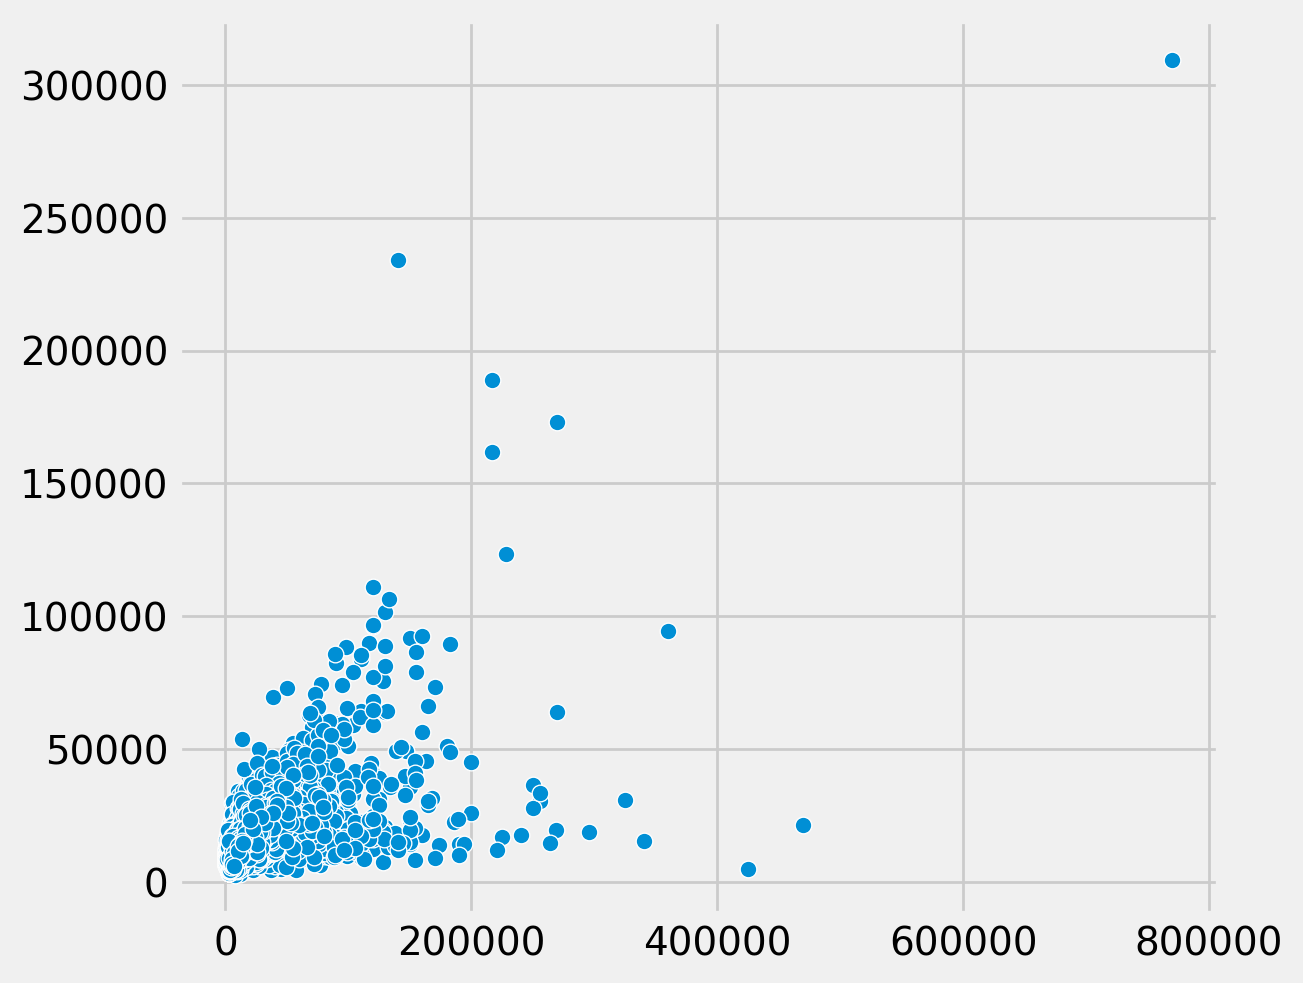

In [42]:
test(model,iter_dict['trn'],criterion,device)

8893.679274630944 	r2 :  0.2637070417404175 	mape :  0.38829714


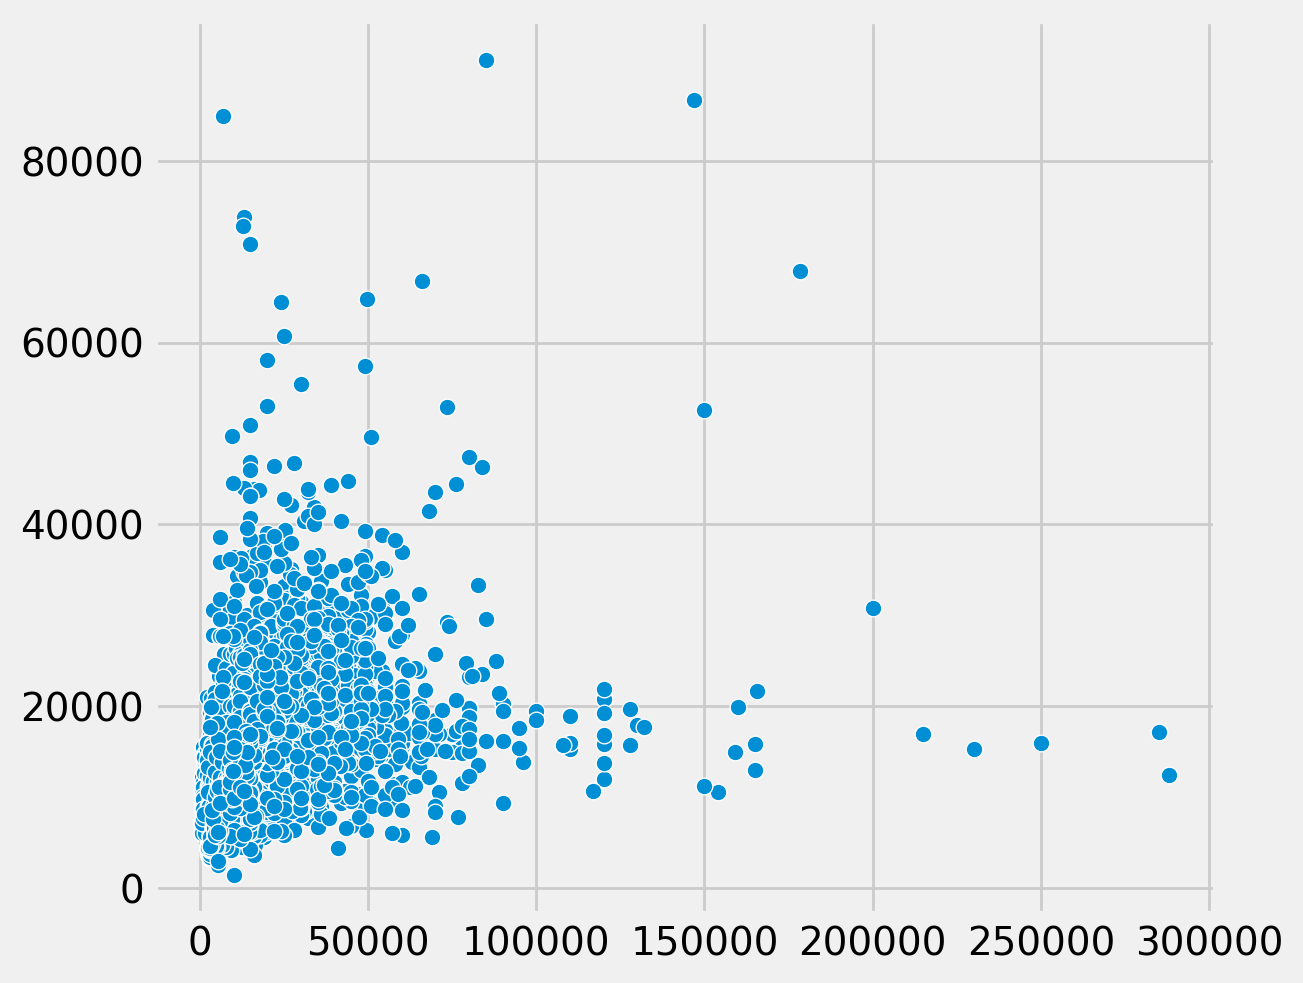

In [43]:
test(model,iter_dict['vld'],criterion,device)

10034.55642171816 	r2 :  0.23794770240783691 	mape :  0.3980246


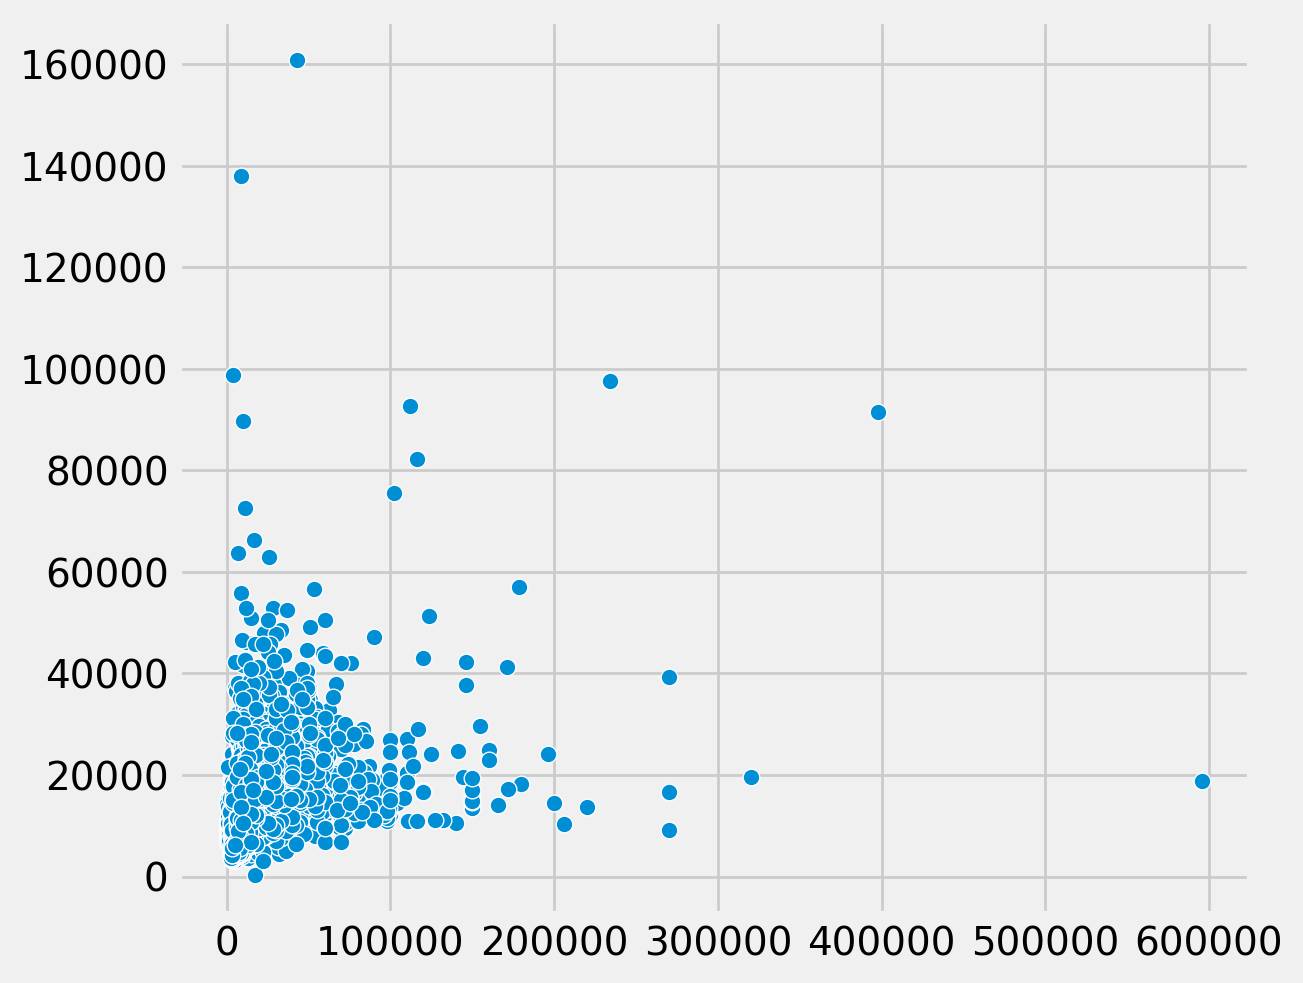

In [44]:
test(model,iter_dict['tst'],criterion,device)

### make trainer

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


## submodule layers

In [ ]:
import torch
from torch import nn
import math

In [ ]:
# torch.nn.Linear : in_features, out_features,bias:bool
# i.e. Linear(a,b) : b*a matrix

class ScaleDotProductAttention(nn.Module):
  def __init__(self):
    super()._init_()
    self.softmax = nn.Softmax(dim=-1)

  def forward(self,q,k,v,mask=None):
    # q : (batch_size, head, seq_len, head_dim) array
    # head_dim = d_k
    _,_,_,head_dim = q.size()
    attention_score = torch.matmul(q,k.transpose(-1,-2))
    attention_score /= math.sqrt(head_dim)

    # mask : 단어는 1, 마스킹 된 곳은 0으로 표시되어 있음
    if mask is not None:
      attention_score = attention_score.masked_fill(mask==0,-1e10)

    attention_score = self.softmax(attention_score)
    return torch.matmul(attention_score,v)

class PositionWiseFCFeedForwardNetwork(nn.Module):
  def __init__(self,d_model,d_ff):
    super()._init_()
    self.w_1 = nn.Linear(d_model,d_ff)
    self.relu = nn.ReLU()
    self.w_2 = nn.Linear(d_ff,d_model)

  def forward(self,x):
    x = self.w_1(x)
    x = self.relu(x)
    x = self.w_2(x)
    return x
#https://code-angie.tistory.com/7

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self,d_model,head):
    # d_model : dim of model input (output of embedding layer)
    # head = num of head,
    # w_q,w_k : d_model * d_k
    # w_v : d_model * d_v
    # w_o : h d_v * d_model
    # in paper, d_k = d_v, hd_v = d_model

    super()._init_()
    self.head = head
    self.head_dim = d_model // head
    self.w_q = nn.Linear(d_model,d_model)
    self.w_k = nn.Linear(d_model,d_model)
    self.w_v = nn.Linear(d_model,d_model)
    self.w_o = nn.Linear(d_model,d_model)
    self.attention = ScaleDotProductAttention()

  def forward(self,q,k,v,mask=None):
    batch_size,_,_ = q.size()
    q,k,v = self.w_q(q), self.w_k(k),self.w_v(v)

    q = q.view(batch_size,-1,self.head,self.head_dim).transpose(1,2)
    k = k.view(batch_size,-1,self.head,self.head_dim).transpose(1,2)
    v = v.view(batch_size,-1,self.head,self.head_dim).transpose(1,2)
    #Tensor.view ~ reshape, Tensor.transpose(dim0,dim1)

    out, attention_score = self.attention(q,k,v,mask)

    out = out.transpose(1,2).contiguous().view(batch_size,-1,self.d_model)

    out = self.w_o(out)

    return out, attention_score

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self,d_model,max_len,device):
    self.P_E = torch.zeros(max_len,d_model,device=device)
    self.P_E.requires_grad = False #i.e. it will not change by training
    pos = torch.arange(0,max_len,dtype=torch.float,device=device).unsqueeze(dim=1)
    #Tensor.unsqueuze(dim=n) : n-th dim added i.e. (3,20,128).unsqueeze(dim=1) -> (3,1,20,128)
    _2i = torch.arange(0,d_model,step=2,dtype=torch.float,device=device)
    self.P_E[:,0::2] = torch.sin(pos/10000 ** (_2i/d_model))
    self.P_E[:,1::2] = torch.cos(pos/10000 ** (_2i/d_model))

  def forward(self,x):
    batch_size,seq_len = x.size()
    return self.P_E[:seq_len,:]

### Encoder layer and Encoder layer with memory

In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self,d_model,head,d_ff,dropout):
    super().__init__()
    self.attention = MultiHeadAttention(d_model,head)
    self.layerNorm1 = nn. LayerNorm(d_model)
    self.ffn = PositionWiseFCFeedForwardNetwork(d_model,d_ff)
    self.layerNorm2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(p=dropout)

  def forward(self,x,padding_mask):
    residual = x
    x, attention_score = self.attention(q=x,k=x,v=x,mask=padding_mask)
    x = self.dropout(x)+residual
    x = self.layerNorm1(x)

    residual = x
    x = self.ffn(x)
    x = self.dropout(x)+residual
    x = self.layerNorm2(x)

    return x, attention_score

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self,d_model,head,d_ff,dropout):
    super().__init__()
    self.attention1 = MultiHeadAttention(d_model,head)
    self.layerNorm1 = nn. LayerNorm(d_model)
    self.attention2 = MultiHeadAttention(d_model,head)
    self.layerNorm2 = nn. LayerNorm(d_model)
    self.ffn = PositionWiseFCFeedForwardNetwork(d_model,d_ff)
    self.layerNorm3 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(p=dropout)

  def forward(self,x,memory,padding_mask):
    residual = x
    x,_  = self.attention1(q=x,k=x,v=x,mask=padding_mask)
    x = self.dropout(x)+residual
    x = self.layerNorm1(x)

    x,_  = self.attention2(q=x,k=memory,v=memory,mask=padding_mask)
    x = self.dropout(x)+residual
    x = self.layerNorm2(x)

    residual = x
    x = self.ffn(x)
    x = self.dropout(x)+residual
    x = self.layerNorm3(x)

    return x

## Module

In [ ]:
class BasicEncoder(nn.Module):
  def __init__(self,n_input,d_model,head,d_ff,max_len,padding_idx,dropout,n_layers,device): #변수 그냥 복붙했는데 체크해봐야함
    super().__init__()

    self.pos_encoding = PositionalEncoding(d_model,max_len,device)
    self.droput = nn.Dropout(p=dropout)

    self.encoding_layers = nn.ModuleList([EncoderLayer(d_model=d_model,
                                                       head = head, d_ff=d_ff,
                                                       dropout = dropout)
                                              for _ in range(n_layers)])

  def forward(self,x,padding_mask):
    pos_encoding = self.pos_encoding(x)
    x = self.dropout(x + pos_encoding)

    for encoder in self.encoding_layers:
      x,attention_score = encoder(x,padding_mask)

    return x

In [ ]:
class EncoderWithEmbedding(BasicEncoder):
  def __init__(self,n_input,d_model,head,d_ff,max_len,padding_idx,dropout,n_layers,device):
    super().__init__(n_input,d_model,head,d_ff,max_len,padding_idx,dropout,n_layers,device)
    self.input_emb = nn.Embedding(n_input,d_model,padding_idx = padding_idx)

  def forward(self,x,padding_mask):
    input_emb = self.input_emb(x)
    return super().forward(input_emb,padding_mask)

# Model

## 1. basic encoder module only

1. Category, BName, BName_sub 에 대해 각각 2 번의 encoding layer를 적용하기

2. encoing layer들의 결과값들을 concat한 뒤 encoding layer 2번 적용하기

3. 회귀예측 결과 출력

In [ ]:
class Model1(nn.Module):
  def __init__(self,n_input,n_output,d_model,head,d_ff,max_len,padding_idx,dropout,n_layers,col_start,device): #변수 그냥 복붙했는데 체크해봐야함
    super().__init__()
    self.padding_idx = padding_idx
    self.device=device
    self.col_start = col_start

    self.base_encoder = BasicEncoder(n_input,d_model,head,d_ff,max_len,padding_idx,dropout,n_layers,device) #변수 그냥 복붙했는데 체크해봐야함
    self.embd_encoder = [EncoderWithEmbedding(n_input,d_model,head,d_ff,max_len,padding_idx,dropout,n_layers,device) #변수 그냥 복붙했는데 체크해봐야함
                          for _ in range(len(col_start)-1)]
    self.linear = nn.Linear(d_model,n_output)

  def cut_vec(self,src,col_start):
    return [src[:,i:j] for i,j in zip(col_start[:-1],col_start[1:])]

  def make_padding_mask(self,q,k): #내용 체크해봐야 함
    _,q_seq_len = q.size()
    _,k_seq_len = k.size()

    q = q.ne(self.padding_idx) #padding token을 0, 나머지를 1로 만들어줌
    q = q.unsqueeze(1).unsqueuze(3) # q : (batch_size,1,q_seq_len,1)
    q = q.repeat(1,1,1,k_seq_len) # q : (batch_size,1,q_seq_len,k_seq_len)

    k = k.ne(self.padding_idx) #padding token을 0, 나머지를 1로 만들어줌
    k = k.unsqueeze(1).unsqueuze(2) # k : (batch_size,1,1,k_seq_len)
    k = k.repeat(1,1,q_seq_len,1) # k: (batch_size,1,q_seq_len,k_seq_len)

    return q & k

  def forward(self,src): #차원 체크해봐야 함
    vecs = self.cut_vec(src,self.col_start)
    intrmd, masks = [], []

    for vec,encoder in zip(vecs[:-1],self.embd_encoder):
      padding_mask = self.make_padding_mask(vec,vec)
      intrmd.append(encoder(vec,padding_mask))
      masks.append(padding_mask)
    intrmd.append(vecs[-1])
    masks.append(torch.ones(vecs[-1].size()))

    output = torch.cat(intrmd,dim=1)
    extnd_mask = torch.cat(masks,dim=1)
    output = self.base_encoder(output,extnd_mask)
    output = self.linear(output)

    return output


### Train

### Evaluate


## 2. using module has attention layer with memory

## 3. using decoder module